# Emotion recognition using Emo-DB dataset and scikit-learn

### Database: Emo-DB database (free) 7 emotions
The data can be downloaded from http://emodb.bilderbar.info/index-1024.html

Code of emotions

W->Anger->Wut

L->Boredom->Langeweile

E->Disgust->Ekel

A->Anxiety/Fear->Angst

F->Happiness->Freude

T->Sadness->Trauer

N->Neutral


![image.png](http://iis-projects.ee.ethz.ch/images/thumb/a/a6/Emotions-on-arousal-valence-space.jpg/450px-Emotions-on-arousal-valence-space.jpg)

In [19]:
import requests 
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import itertools
import sys
sys.path.append("../")

# disvoice imports
from phonation.phonation import Phonation
from articulation.articulation import Articulation
from prosody.prosody import Prosody
from phonological.phonological import Phonological

# sklearn methods
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm

## Download and unzip data


In [2]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
            
PATH_data="http://emodb.bilderbar.info/download/download.zip"

In [3]:
download_url(PATH_data, "./download.zip")

In [4]:
with zipfile.ZipFile("./download.zip", 'r') as zip_ref:
    zip_ref.extractall("./emo-db/")

## prepare labels from the dataset

we will get labels for two classification problems: 

1. high vs. low arousal emotions
2. positive vs. negative emotions


In [2]:
PATH_AUDIO=os.path.abspath("./emo-db/wav")+"/"
labelsd='WLEAFTN'
labelshl=  [0, 1, 0, 0, 0, 1, 1] # 0 high arousal emotion, 1 low arousal emotions
labelspn=  [0, 0, 0, 0, 1, 0, 1] # 0 negative valence emotion, 1 positive valence emotion

hf=os.listdir(PATH_AUDIO)
hf.sort()

yArousal=np.zeros(len(hf))
yValence=np.zeros(len(hf))
for j in range(len(hf)):
    name_file=hf[j]
    label=hf[j][5]
    poslabel=labelsd.find(label)
    yArousal[j]=labelshl[poslabel]
    yValence[j]=labelspn[poslabel]

## compute features using disvoice: phonation, articulation, prosody, phonological

In [3]:
phonationf=Phonation()
articulationf=Articulation()
prosodyf=Prosody()
phonologicalf=Phonological()


Instructions for updating:
Colocations handled automatically by placer.


### phonation features

In [4]:
Xphonation=phonationf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="npy")
print(Xphonation.shape)

Processing 14a07Aa.wav:  69%|██████▉   | 369/535 [00:09<00:04, 33.27it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [00:14<00:00, 37.79it/s]


(535, 28)


### articulation features

In [5]:
Xarticulation=articulationf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="npy")
print(Xarticulation.shape)

Processing 16b10Wb.wav: 100%|██████████| 535/535 [04:00<00:00,  2.21it/s]

(535, 488)


### prosody features

In [6]:
Xprosody=prosodyf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="npy")
print(Xprosody.shape)

Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [01:20<00:38,  4.23it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Processing 14a07Fd.wav:  70%|██████▉   | 372/535 [01:21<00:34,  4.72it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Processing 14a07Na.wav:  70%|███████   | 375/535 [01:21<00:29,  5.52it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Processing 14a07Wc.wav:  70%|███████   | 377/535 [01:22<00:31,  5.08it/s]/home/camilo/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [01:53<00:00,  6.09it/s]

(535, 103)


### phonological features

In [8]:
Xphonological=phonologicalf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="npy")
print(Xphonological.shape)

Processing 16b10Wb.wav: 100%|██████████| 535/535 [02:58<00:00,  2.67it/s]

(535, 108)


### Emotion classification using an SVM classifier



In [24]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    cm = metrics.confusion_matrix(y_true, y_pred)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()



def classify(X, y):
    
    # train test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=42)
    
    # z-score standarization
    scaler = preprocessing.StandardScaler().fit(Xtrain) 
    Xtrain=scaler.transform(Xtrain) 
    Xtest=scaler.transform(Xtest)
    Results=[]
    
    # randomized search cross-validation to optimize hyper-parameters of SVM 
    parameters = {'kernel':['rbf'], 'class_weight': ['balanced'], 
            'C':st.expon(scale=10),
            'gamma':st.expon(scale=0.01)}

    svc = svm.SVC()

    clf=RandomizedSearchCV(svc, parameters, n_jobs=4, cv=10, verbose=1, n_iter=500, scoring='balanced_accuracy')

    clf.fit(Xtrain, ytrain) # train the SVM
    accDev= clf.best_score_ # validation accuracy
    Copt=clf.best_params_.get('C') # best C
    gammaopt=clf.best_params_.get('gamma') # best gamma
    
    # train the SVM with the optimal hyper-parameters
    cls=svm.SVC(kernel='rbf', C=Copt, gamma=gammaopt, class_weight='balanced') 
    cls.fit(Xtrain, ytrain)
    ypred=cls.predict(Xtest) # test predictions
    acc=metrics.accuracy_score(ytest, ypred)
    cm=metrics.confusion_matrix(ytest, ypred)
    score_test=cls.decision_function(Xtest)
    AUC=metrics.roc_auc_score(ytest, score_test)
    dfclass=metrics.classification_report(ytest, ypred,digits=4)

    # display the results
    
    plot_confusion_matrix(ytest, ypred, classes=["class 0", "class 1"], normalize=True)
    
    plt.figure(figsize=(5,5))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    fprs, tprs, thresholds = metrics.roc_curve(ytest, score_test)
    plt.plot(fprs, tprs, color='k',
         label=r'Avg. ROC (AUC = %0.3f)' % (AUC),
         lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    
    plt.show()
    print("Accuracy: ", acc)
    print(dfclass)

    


## classify high vs. low arousal with the different feature sets

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 1164 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:    9.5s finished


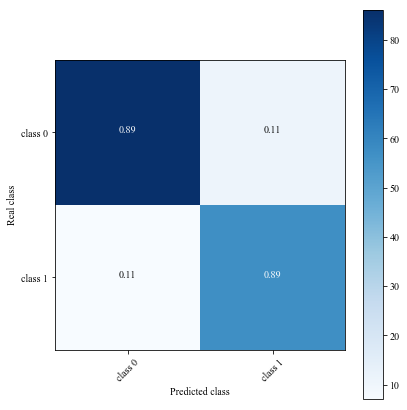

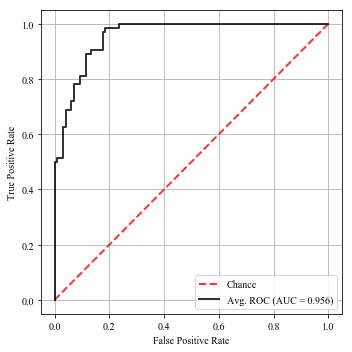

Accuracy:  0.8881987577639752
              precision    recall  f1-score   support

         0.0     0.9247    0.8866    0.9053        97
         1.0     0.8382    0.8906    0.8636        64

    accuracy                         0.8882       161
   macro avg     0.8815    0.8886    0.8844       161
weighted avg     0.8903    0.8882    0.8887       161



In [25]:
classify(Xphonation, yArousal)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   27.2s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:  2.6min finished


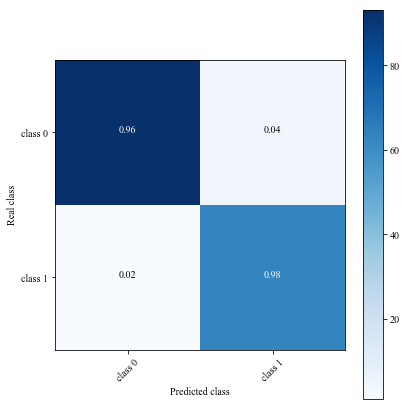

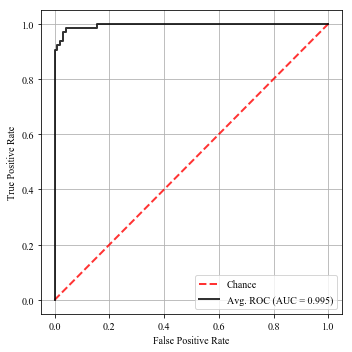

Accuracy:  0.968944099378882
              precision    recall  f1-score   support

         0.0     0.9894    0.9588    0.9738        97
         1.0     0.9403    0.9844    0.9618        64

    accuracy                         0.9689       161
   macro avg     0.9648    0.9716    0.9678       161
weighted avg     0.9699    0.9689    0.9691       161



In [26]:
classify(Xarticulation, yArousal)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 688 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 3688 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   26.5s finished


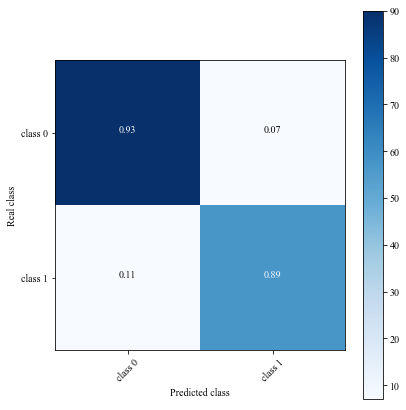

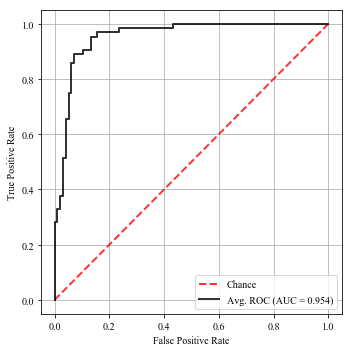

Accuracy:  0.9130434782608695
              precision    recall  f1-score   support

         0.0     0.9278    0.9278    0.9278        97
         1.0     0.8906    0.8906    0.8906        64

    accuracy                         0.9130       161
   macro avg     0.9092    0.9092    0.9092       161
weighted avg     0.9130    0.9130    0.9130       161



In [27]:
classify(Xprosody, yArousal)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 416 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 2216 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   35.6s finished


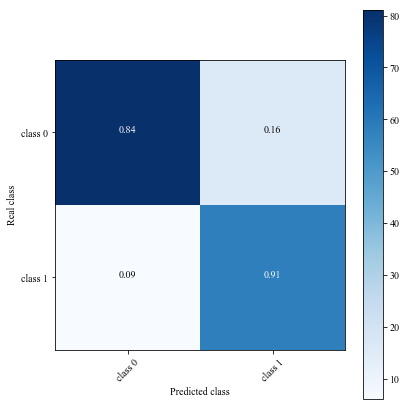

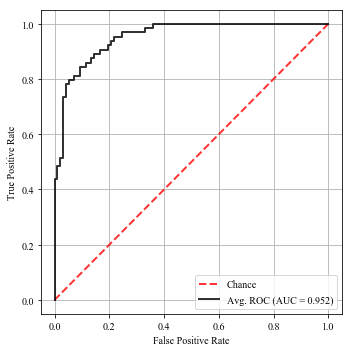

Accuracy:  0.8633540372670807
              precision    recall  f1-score   support

         0.0     0.9310    0.8351    0.8804        97
         1.0     0.7838    0.9062    0.8406        64

    accuracy                         0.8634       161
   macro avg     0.8574    0.8707    0.8605       161
weighted avg     0.8725    0.8634    0.8646       161



In [28]:
classify(Xphonological, yArousal)

## classify positive vs. negative valence with the different feature sets

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 892 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 4792 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   19.9s finished


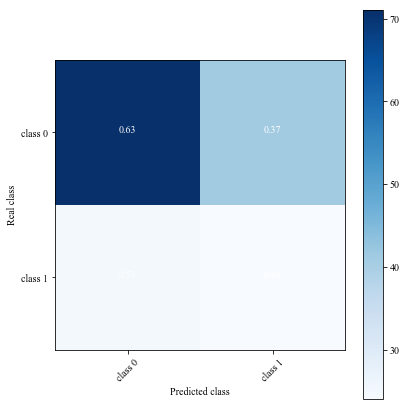

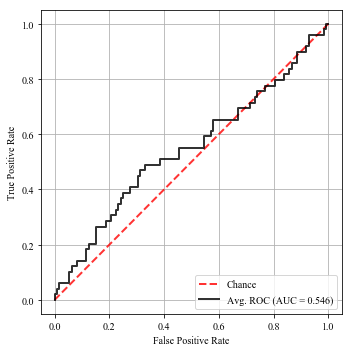

Accuracy:  0.5900621118012422
              precision    recall  f1-score   support

         0.0     0.7396    0.6339    0.6827       112
         1.0     0.3692    0.4898    0.4211        49

    accuracy                         0.5901       161
   macro avg     0.5544    0.5619    0.5519       161
weighted avg     0.6269    0.5901    0.6031       161



In [29]:
classify(Xphonation, yValence)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   27.0s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   56.5s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:  2.7min finished


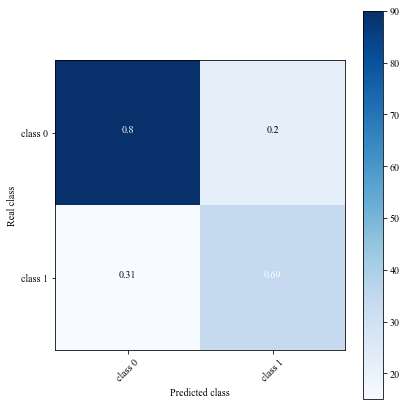

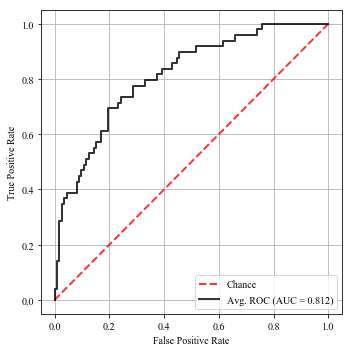

Accuracy:  0.7701863354037267
              precision    recall  f1-score   support

         0.0     0.8571    0.8036    0.8295       112
         1.0     0.6071    0.6939    0.6476        49

    accuracy                         0.7702       161
   macro avg     0.7321    0.7487    0.7386       161
weighted avg     0.7811    0.7702    0.7741       161



In [30]:
classify(Xarticulation, yValence)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 1848 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 4348 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   36.3s finished


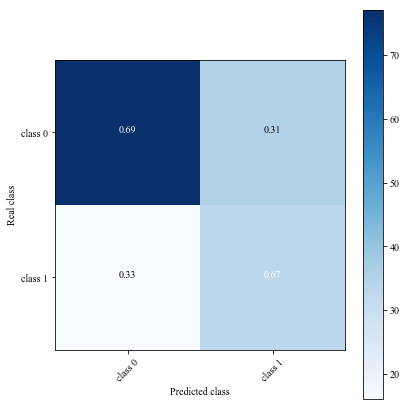

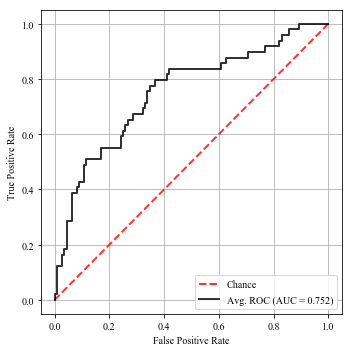

Accuracy:  0.6832298136645962
              precision    recall  f1-score   support

         0.0     0.8280    0.6875    0.7512       112
         1.0     0.4853    0.6735    0.5641        49

    accuracy                         0.6832       161
   macro avg     0.6566    0.6805    0.6577       161
weighted avg     0.7237    0.6832    0.6943       161



In [31]:
classify(Xprosody, yValence)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 416 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 2216 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   43.3s finished


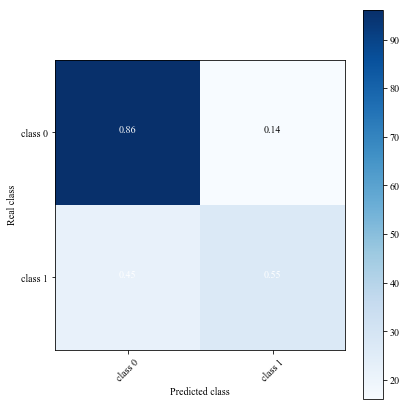

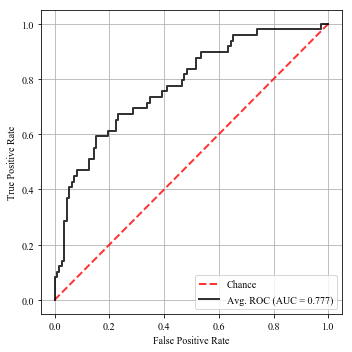

Accuracy:  0.7639751552795031
              precision    recall  f1-score   support

         0.0     0.8136    0.8571    0.8348       112
         1.0     0.6279    0.5510    0.5870        49

    accuracy                         0.7640       161
   macro avg     0.7207    0.7041    0.7109       161
weighted avg     0.7571    0.7640    0.7594       161



In [32]:
classify(Xphonological, yValence)